In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# location to save figures
import os
cwd = os.getcwd()
data_path = cwd + '/../data/'

# COSMOS Data

## COSMOS Survey

In [118]:
# survey area
area_square_degrees = 1.38  # number from Aaron
area_steradians =  area_square_degrees*1.0/(180.0/np.pi)**2

# survey volume
zmax = 1.0
zmin = 0.75

from cosmo_utils.cosmic_volume import comoving_volume
volume = comoving_volume(zmax, area_steradians) - comoving_volume(zmin, area_steradians)
volume = volume/(1000.0)**3  # h^-3 Gpc^3

print("survey volume: {0} h^-3 Gpc^3".format(volume))

survey volume: 0.000840100213186 h^-3 Gpc^3


## Load COSMOS Catalog

In [119]:
from astropy.table import Table, hstack

littleh = 0.7

# load catalog 1
fname = 'COSMOS2015_UVista_cat_withzCOSMOS_withChandra.fits'
data1 = Table.read(data_path + fname)

# load catalog 2
fname = 'COSMOS_0.5_2.5_cosmos2015_masses_toDuncan.fits'
data2 = Table.read(data_path + fname)

# combine catalogs
from halotools.utils import crossmatch
id1, id2 = crossmatch(data1['NUMBER'], data2['ID'])

data = hstack([data1[id1], data2[id2]])

for key in sorted(data.keys()):
    print(key)
    
# convert to h=1 scalings
data['MASS_SC'] = (10**data['MASS_SC'])*littleh**2

ALPHA_J2000
B_MAGERR_APER3
B_MAG_APER3
CC_zCOSMOSDR3
CHI2_BEST
CHIQ
DELTA_J2000
EBV
FLAG_COSMOS
FLAG_DEEP_1
FLAG_DEEP_2
FLAG_HJMCC
FLAG_PETER
FLAG_SHALLOW
H_MAGERR_APER3
H_MAG_APER3
Hw_MAGERR_APER3
Hw_MAG_APER3
IA484_MAGERR_APER3
IA484_MAG_APER3
IA527_MAGERR_APER3
IA527_MAG_APER3
IA624_MAGERR_APER3
IA624_MAG_APER3
IA679_MAGERR_APER3
IA679_MAG_APER3
IA738_MAGERR_APER3
IA738_MAG_APER3
IA767_MAGERR_APER3
IA767_MAG_APER3
IB427_MAGERR_APER3
IB427_MAG_APER3
IB464_MAGERR_APER3
IB464_MAG_APER3
IB505_MAGERR_APER3
IB505_MAG_APER3
IB574_MAGERR_APER3
IB574_MAG_APER3
IB709_MAGERR_APER3
IB709_MAG_APER3
IB827_MAGERR_APER3
IB827_MAG_APER3
ID
ID_CHANDRA2016
ID_XMM
J_MAGERR_APER3
J_MAG_APER3
KMAG
Ks_MAGERR_APER3
Ks_MAG_APER3
Ksw_MAGERR_APER3
Ksw_MAG_APER3
LGSFR_SC
L_K
MAGERR_24
MAG_24
MASS_SC
MB
MH
MI
MJ
MK
MR
MU
MV
MY
MZ
NB711_MAGERR_APER3
NB711_MAG_APER3
NB816_MAGERR_APER3
NB816_MAG_APER3
NUMBER
OFFSET
PHOTOZ
Qg
SNR_zCOSMOSDR3
SPLASH_1_MAG
SPLASH_1_MAGERR
SPLASH_2_MAG
SPLASH_2_MAGERR
SPLASH_3_MAG
SPLA

## Selection

In [127]:
z_mask =(data['PHOTOZ']>0.75) & (data['PHOTOZ']<1.0)
mstar_mask = (data['MASS_SC'] > 10**9.1)
chi2_mask = data['CHI2_BEST'] < 2.5
kmag_mask = data['KMAG'] < 23.4
type_mask = data['TYPE_2']==0

selection_mask = z_mask & mstar_mask & chi2_mask & kmag_mask & type_mask 

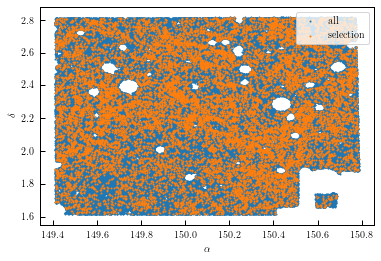

In [144]:
plt.figure()
p1 = plt.scatter(data['ALPHA_J2000'], data['DELTA_J2000'],s=1)
p2 = plt.scatter(data['ALPHA_J2000'][selection_mask], data['DELTA_J2000'][selection_mask],s=1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')
plt.legend([p1,p2], ['all','selection'],
           loc='upper right', frameon=True, fontsize=10)
plt.show()

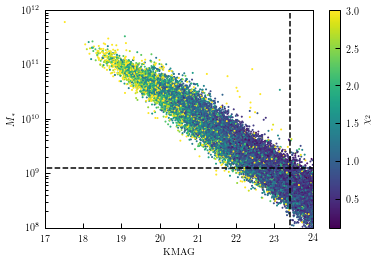

In [138]:
mask = z_mask

plt.figure()
plt.scatter(data['KMAG'][mask], data['MASS_SC'][mask],c=data['CHI2_BEST'][mask], s=1, vmax=3.0)
plt.plot([23.4, 23.4],[10**0,10**15],'--',color='black')
plt.plot([0,100],[10**9.1,10**9.1],'--',color='black')
plt.ylim([10**8,10**12])
plt.yscale('log')
plt.xlim([17,24])
plt.xlabel(r'$\rm K MAG$')
plt.ylabel(r'$M_{*}$')
plt.colorbar(label=r'$\chi_2$')
plt.show()

## Stellar Mass Function

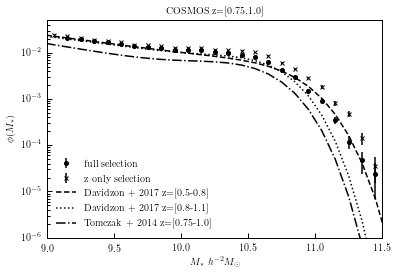

In [155]:
from legac_mocks.galaxy_abundance_functions import Davidzon_2017_phi, Tomczak_2014_phi

phi_model_1 = Davidzon_2017_phi(redshift=0.5)
phi_model_2 = Davidzon_2017_phi(redshift=0.8)
phi_model_3 = Tomczak_2014_phi(redshift=0.8)

mask = selection_mask

mstar_bins = np.arange(8,12,0.1)
mstar_bin_centers = (mstar_bins[:-1]+mstar_bins[1:])/2.0

from stat_utils import histogram as custom_histogram
counts, err = custom_histogram(np.log10(data['MASS_SC'][mask]), bins=mstar_bins)
phi = 1.0*counts/0.1/(volume*1000**3)
err = 1.0*err/0.1/(volume*1000**3)

counts_1, err_1 = custom_histogram(np.log10(data['MASS_SC'][z_mask]), bins=mstar_bins)
phi_1 = 1.0*counts_1/0.1/(volume*1000**3)
err_1 = 1.0*err_1/0.1/(volume*1000**3)




plt.figure()
plt.title('COSMOS z=[0.75,1.0]')
p1 = plt.errorbar(mstar_bin_centers, phi, yerr=err, fmt='o', color='black', ms=4)
p2 = plt.errorbar(mstar_bin_centers, phi_1, yerr=err_1, fmt='x', color='black', ms=4)
l1, = plt.plot(mstar_bin_centers, phi_model_1(10**mstar_bin_centers), '--', color='black')
l2, = plt.plot(mstar_bin_centers, phi_model_2(10**mstar_bin_centers), ':', color='black')
l3, = plt.plot(mstar_bin_centers, phi_model_3(10**mstar_bin_centers), '-.', color='black')
plt.xlim([9,11.5])
plt.yscale('log')
plt.ylim([0.000001,0.05])
plt.xlabel(r'$M_*~h^{-2}M_{\odot}$')
plt.ylabel(r'$\phi(M_*)$')
plt.legend([p1,p2,l1, l2, l3],['full selection',
                               'z only selection',
                               'Davidzon + 2017 z=[0.5-0.8]',
                               'Davidzon + 2017 z=[0.8-1.1]',
                               'Tomczak + 2014 z=[0.75-1.0]'],
           loc='lower left', frameon=False, fontsize=10)
plt.show()